In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement
bin_size = 101

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

## Libraries

In [4]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [5]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

def RHsurf(T,qv,P0,PS):
    R = 287
    Rv = 461
    
    return Rv*PS*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    
    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

In [6]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [7]:
def CRH(inp,input_sub,input_div):

    qv0 = inp[:,:30]*input_div[:30]+input_sub[:30]
    T = inp[:,30:60]*input_div[30:60]+input_sub[30:60]
    ps = inp[:,60]*input_div[60]+input_sub[60]

    dP0 = dP(ps)
    qsat0 = qsat(T,P0,ps,hyam,hybm)

    return np.sum(qv0*dP0,axis=1)/np.sum(qsat0*dP0,axis=1)

In [8]:
def qsatsurf(TS,P0,PS):
    R = 287
    Rv = 461
    return R*esat(TS)/(Rv*PS)

In [9]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            if np.sum(w)>0: Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)
            else: Ym[ibin-1] = np.nan; Ystd[ibin-1] = np.nan;

        edge_left = edge
    
    return Ym,Ystd

## Load Data

In [10]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
#path = '/scratch/05823/tg851228/CBRAIN/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'

# datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                           decode_times=False)
datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                          decode_times=False)


In [11]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
#path = '/scratch/05823/tg851228/CBRAIN/sp8fbp_4k/sp8fbp_4k.cam2.h2.'

# datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
datap4K = xr.open_mfdataset(path+'0001-0?-15-00000.nc',\
                           decode_times=False)

In [12]:
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
#path = '/scratch/05823/tg851228/CBRAIN/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
# dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                           decode_times=False)

In [32]:
datam4K.QAP.shape

(432, 30, 64, 128)

In [37]:
datam4K.QAP.shape

(5184, 30, 64, 128)

In [ ]:
pdf = {}
edg = {}

for ilev in range(30):
    print('ilev=',ilev,'        ',end='\r')

    pdf[isim][ilev] = {}
    edg[isim][ilev] = {}

    for ifield,field in enumerate(['PHQ','TPHYSTND']):

        if ifield==0: prefac = L_V*dP/G
        elif ifield==1: prefac = C_P*dP/G

        pdf[isim][ilev][field],edg[isim][ilev][field] = \
        np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=100)

## Percentile Distribution

In [13]:
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [14]:
dataref.PHQ.shape

(432, 30, 64, 128)

In [15]:
datam4K.PHQ.shape

(432, 30, 64, 128)

In [16]:
dataref.FSNT.shape

(432, 64, 128)

In [17]:
scale_dict = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_dP.pkl')

In [18]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        pdf[isim][ilev] = {}
        edg[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            pdf[isim][ilev][field],edg[isim][ilev][field] = \
            np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=100)

isim= 0          
isim= 1          
isim= 2          


In [19]:
pdf[0][0]['PHQ']

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0, 3538944,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,     

In [72]:
data = datam4K
prefac = L_V*dP/G
field = 'PHQ'
ilev = 15

(array([2.000000e+00, 1.000000e+00, 4.000000e+00, 6.000000e+00,
        4.600000e+01, 1.620000e+02, 6.480000e+02, 1.904000e+03,
        4.591000e+03, 1.025200e+04, 1.910800e+04, 4.712300e+04,
        3.425926e+06, 2.715300e+04, 1.452000e+03, 3.440000e+02,
        1.370000e+02, 6.200000e+01, 1.800000e+01, 5.000000e+00]),
 array([-304.81177 , -280.80637 , -256.80096 , -232.79555 , -208.79015 ,
        -184.78474 , -160.77934 , -136.77394 , -112.76853 ,  -88.76312 ,
         -64.75772 ,  -40.752316,  -16.746912,    7.258493,   31.263897,
          55.269302,   79.274704,  103.28011 ,  127.285515,  151.29092 ,
         175.29633 ], dtype=float32),
 <a list of 20 Patch objects>)

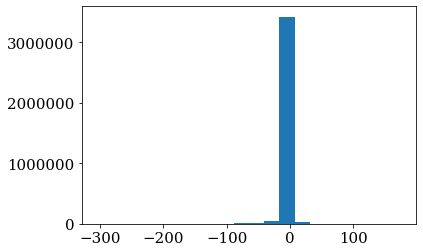

In [21]:
plt.hist(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=20)

**Percentiles**

In [14]:
PERC = np.linspace(0,100,bin_size).astype('int')

In [15]:
PERC

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [18]:
perc = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    perc[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        perc[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            perc[isim][ilev][field] = {}
            perc[isim][ilev][field] = \
            np.percentile(a=prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),q=PERC)

isim= 0          
isim= 1          
isim= 2          


In [19]:
perc

{0: {0: {'PHQ': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
   'TPHYSTND': array([-1.87312984, -1.66786001, -1.63322157, -1.60518344, -1.57367049,
          -1.52312073, -1.45372442, -1.37850403, -1.30600349, -1.24327153,
          -1.19438773, -1.15573091, -1.12365053, -1.09679816, -1.07462847,
          -1.05544118, -1.03813542, -1.02213848, -1.0070144 , -0.99277249,
          -0.97918651, -0.96611969, -0.95327199, -0.94057053, -0.92791449,
          -0.91554129, -0.90297117, -0.89018374, -0.87722927, -0.86378406,
          -0.84965714, -0.83450733, -0.81792947, -0.7994281

**pdf of percentiles**

In [39]:
L_V*dP/G

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

In [26]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        pdf[isim][ilev] = {}
        edg[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            pdf[isim][ilev][field],edg[isim][ilev][field] = \
            np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=perc[isim][ilev][field])

isim= 0          
isim= 1          
isim= 2          


In [27]:
edg2bin(edg[isim][0+15]['PHQ'])

array([-7.27781333e+02, -7.79469299e+01, -3.66540341e+01, -2.38390986e+01,
       -1.72423076e+01, -1.31739733e+01, -1.03696375e+01, -8.36244628e+00,
       -6.89258912e+00, -5.76736454e+00, -4.88490234e+00, -4.17815161e+00,
       -3.60491002e+00, -3.13673122e+00, -2.74855564e+00, -2.42179374e+00,
       -2.14568799e+00, -1.91143544e+00, -1.71137060e+00, -1.53791354e+00,
       -1.38423452e+00, -1.24697067e+00, -1.12454741e+00, -1.01462079e+00,
       -9.16161741e-01, -8.27621352e-01, -7.47859044e-01, -6.75784397e-01,
       -6.10117764e-01, -5.50602383e-01, -4.96667714e-01, -4.47684839e-01,
       -4.03196874e-01, -3.62568114e-01, -3.25623604e-01, -2.92137098e-01,
       -2.61795493e-01, -2.34377895e-01, -2.09379087e-01, -1.86683276e-01,
       -1.66039397e-01, -1.47260187e-01, -1.30304663e-01, -1.14899221e-01,
       -1.00821039e-01, -8.80157617e-02, -7.63690626e-02, -6.57656873e-02,
       -5.61067998e-02, -4.73342586e-02, -3.93828218e-02, -3.21591287e-02,
       -2.56358020e-02, -

In [28]:
edg[isim][0+15]['PHQ']

array([-1.34497595e+03, -1.10586714e+02, -4.53071452e+01, -2.80009229e+01,
       -1.96772743e+01, -1.48073410e+01, -1.15406057e+01, -9.19866936e+00,
       -7.52622320e+00, -6.25895503e+00, -5.27577405e+00, -4.49403064e+00,
       -3.86227259e+00, -3.34754745e+00, -2.92591498e+00, -2.57119631e+00,
       -2.27239118e+00, -2.01898480e+00, -1.80388608e+00, -1.61885512e+00,
       -1.45697196e+00, -1.31149708e+00, -1.18244426e+00, -1.06665056e+00,
       -9.62591028e-01, -8.69732454e-01, -7.85510249e-01, -7.10207838e-01,
       -6.41360955e-01, -5.78874572e-01, -5.22330195e-01, -4.71005232e-01,
       -4.24364445e-01, -3.82029302e-01, -3.43106925e-01, -3.08140282e-01,
       -2.76133914e-01, -2.47457072e-01, -2.21298718e-01, -1.97459456e-01,
       -1.75907096e-01, -1.56171697e-01, -1.38348677e-01, -1.22260650e-01,
       -1.07537793e-01, -9.41042855e-02, -8.19272380e-02, -7.08108871e-02,
       -6.07204874e-02, -5.14931123e-02, -4.31754049e-02, -3.55902387e-02,
       -2.87280188e-02, -

In [29]:
data = datam4K
prefac = L_V*dP/G
field = 'PHQ'
ilev = 0
isim = 0

In [30]:
perc[isim][ilev]['PHQ']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [31]:
np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=perc[isim][ilev][field])

(array([      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
      

**Percentiles for non level dependent vars**

In [74]:
perc_non_dependent = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    perc_non_dependent[isim] = {}
    

    for ifield,field in enumerate(['FSNT', 'FSNS', 'FLNT', 'FLNS']):
        perc_non_dependent[isim][field] = \
        np.percentile(a=data[field][:,:,:].values.flatten(),q=PERC)

isim= 0          
isim= 1          
isim= 2          


In [80]:
perc_non_dependent

{0: {'FSNT': array([   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    5.42443386,   13.25385666,   22.33272146,
           33.19810455,   46.71621861,   60.80536552,   76.31005554,
           92.14023468,

## Preprocess M4k data

### PHQ

In [24]:
PHQ = datam4K.PHQ.stack(sample=('time', 'lat', 'lon'))
PHQ = PHQ.transpose('sample', 'lev')
prefac = L_V*dP/G
lev = 0

In [25]:
PHQ

<xarray.DataArray 'PHQ' (sample: 3538944, lev: 30)>
dask.array<transpose, shape=(3538944, 30), dtype=float32, chunksize=(393216, 30), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * sample   (sample) MultiIndex
  - time     (sample) float64 365.0 365.0 365.0 365.0 ... 374.0 374.0 374.0
  - lat      (sample) float64 -87.86 -87.86 -87.86 -87.86 ... 87.86 87.86 87.86
  - lon      (sample) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:      kg/kg/s
    long_name:  Specific humidity physics tendency

In [26]:
## take a small sample just to visualize
PHQ_small = PHQ[:1000]
PHQ_scaled = prefac[lev]*np.array(PHQ_small[:,lev])

In [31]:
perc[0][lev]['PHQ']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**For 1 specific level** (will be of shape N X bin_size)

In [52]:
enc = OneHotEncoder(sparse=False)
enc.fit(PERC.reshape(-1,1))

OneHotEncoder(sparse=False)

In [53]:
one_hot = enc.transform(bin_index.reshape(-1,1))

In [54]:
one_hot.shape

(1000, 101)

**All levels** (shape should be Nx30xbin_size)

In [69]:
all_levels_one_hot = []
for ilev in range(30):
    PHQ_scaled = prefac[ilev]*np.array(PHQ_small[:,ilev])
    bin_index = np.digitize(PHQ_scaled,perc[0][ilev]['PHQ'],right=True)
    one_hot = enc.transform(bin_index.reshape(-1,1))
    all_levels_one_hot.append(one_hot)
PHQ_one_hot = np.stack(all_levels_one_hot,axis=1)

In [70]:
print(PHQ_one_hot.shape)

(1000, 30, 101)


In [ ]:
[0, 1, 2, 3, 4, 5]
[0,0,0,0,0]

### FSNT

**ALL DPs** (should be of the shape Nxbin_size)

In [87]:
FSNT = datam4K.FSNT.stack(sample=('time', 'lat', 'lon'))

In [88]:
## take a small sample just to visualize
FSNT_small = FSNT[:1000]

In [89]:
bin_index = np.digitize(FSNT_small,perc_non_dependent[0]['FSNT'],right=True)
print(bin_index)

[72 74 71 73 74 70 71 69 66 68 70 73 72 71 72 69 69 70 73 74 75 75 75 75
 76 76 76 76 76 76 76 76 77 75 73 76 76 77 77 74 76 75 78 77 76 72 74 73
 75 75 73 71 71 74 73 72 73 74 74 71 73 74 73 72 72 73 73 73 74 73 73 73
 74 73 74 73 71 73 74 73 73 73 74 73 74 73 74 74 75 73 74 72 73 73 72 73
 73 74 71 72 71 70 73 74 70 73 73 74 74 72 73 72 73 73 73 72 73 75 74 69
 74 74 66 70 73 74 74 74 69 70 69 69 70 69 69 68 68 68 70 70 70 69 69 71
 70 68 71 71 73 72 71 74 74 74 75 75 75 75 76 76 72 74 75 76 77 71 73 73
 73 73 77 74 73 73 73 75 75 76 77 77 77 76 78 77 76 77 76 78 78 77 77 77
 76 77 77 76 78 77 79 79 79 80 79 81 81 80 80 79 81 81 81 79 80 79 80 79
 79 79 77 77 77 76 76 76 76 74 72 74 75 72 74 71 73 74 74 74 71 71 73 71
 71 72 69 70 70 69 69 67 67 68 68 68 66 68 69 65 66 67 66 66 64 64 63 63
 63 64 63 63 63 64 65 65 65 67 67 67 70 70 71 72 72 70 73 73 74 74 75 73
 73 75 75 76 76 78 75 75 75 75 75 75 76 76 78 78 77 78 78 78 80 80 79 81
 81 80 83 84 81 82 83 83 83 83 83 82 78 82 79 81 84

In [92]:
one_hot_fsnt = enc.transform(bin_index.reshape(-1,1))

In [93]:
one_hot_fsnt.shape

(1000, 101)

## Load dumped percentile data

In [13]:
path = '/export/nfs0home/ankitesg/data/percentile_data.pkl'

In [15]:
dumped = load_pickle(path)
perc = dumped['Percentile']

In [16]:
dumped

{'Percentile': {'M4K': {'PHQ': {0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    2: array([-9.27421

In [17]:
pdf_perc = dumped['PDF_PERCENTILE']

In [24]:
pdf_perc['M4K']['PHQ'][29]

array([35390, 35389, 35390, 35389, 35390, 35389, 35390, 35389, 35389,
       35390, 35389, 35390, 35389, 35390, 35389, 35389, 35390, 35389,
       35390, 35389, 35390, 35389, 35389, 35390, 35389, 35390, 35389,
       35390, 35389, 35389, 35390, 35389, 35390, 35389, 35390, 35389,
       35389, 35390, 35389, 35390, 35389, 35390, 35389, 35389, 35390,
       35389, 35390, 35389, 35390, 35389, 35389, 35390, 35389, 35390,
       35389, 35390, 35389, 35389, 35390, 35389, 35390, 35389, 35390,
       35389, 35389, 35390, 35389, 35390, 35389, 35389, 35390, 35389,
       35390, 35389, 35390, 35389, 35390, 35389, 35388, 35391, 35389,
       35390, 35389, 35390, 35389, 35389, 35390, 35389, 35390, 35389,
       35390, 35389, 35389, 35390, 35389, 35390, 35389, 35390, 35389,
       35390])

In [29]:
edg = dumped['BIN_EDGES_PERCENTILE']

In [38]:
scale_dict = load_pickle('/export/nfs0home/ankitesg/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')

In [51]:
edg['M4K']['PHQ'][29]

array([-6.65406006e+02, -9.32800005e+01, -6.95701288e+01, -5.64098322e+01,
       -4.75344814e+01, -4.08727579e+01, -3.56816976e+01, -3.15102735e+01,
       -2.80915211e+01, -2.52119800e+01, -2.27869925e+01, -2.06797311e+01,
       -1.88527779e+01, -1.72553575e+01, -1.58488321e+01, -1.45878876e+01,
       -1.34545642e+01, -1.24344976e+01, -1.15081899e+01, -1.06630386e+01,
       -9.89327545e+00, -9.18272384e+00, -8.51551357e+00, -7.89687013e+00,
       -7.32094971e+00, -6.77239132e+00, -6.25756513e+00, -5.77087302e+00,
       -5.30879112e+00, -4.87210394e+00, -4.45200229e+00, -4.05746447e+00,
       -3.67646948e+00, -3.31037731e+00, -2.96478946e+00, -2.63112551e+00,
       -2.31144955e+00, -2.01055137e+00, -1.71663657e+00, -1.43788815e+00,
       -1.16609952e+00, -9.01767800e-01, -6.45803163e-01, -3.94662419e-01,
       -1.51043335e-01,  8.57223529e-02,  3.24501199e-01,  5.65909880e-01,
        8.05640931e-01,  1.04892034e+00,  1.29604077e+00,  1.54650918e+00,
        1.79754507e+00,  

(-50, 50)

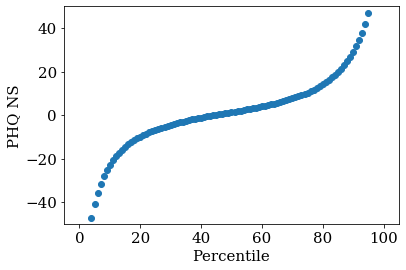

In [53]:
plt.scatter(np.arange(0,101),edg['M4K']['PHQ'][29])
plt.xlabel("Percentile")
plt.ylabel("PHQ NS")
plt.ylim((-50,50))

In [42]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
       3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820160e+08, 3.7970438e+08], dtype=float32)

## PLOT PDF

In [25]:
COL = ['b','gray','r']

No handles with labels found to put in legend.


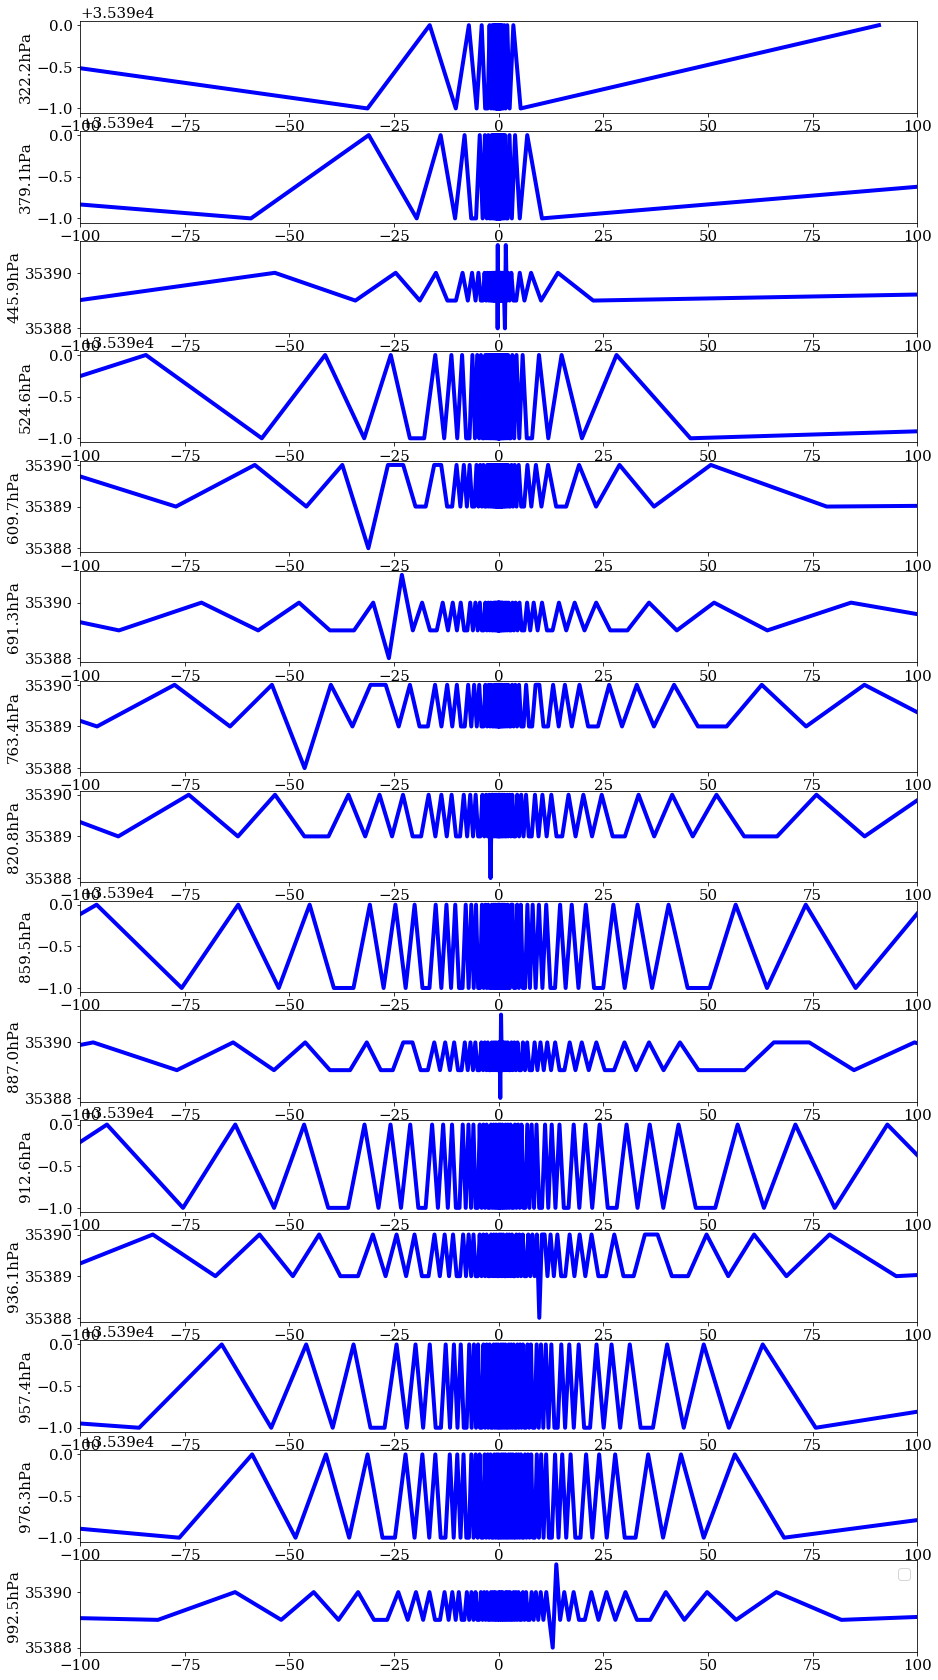

In [32]:
fig,ax = plt.subplots(15,1,figsize=(15,30))

for ilev in range(15):

    ax[ilev].plot(edg2bin(edg['M4K']['PHQ'][ilev+15]),pdf_perc["M4K"]['PHQ'][ilev+15],color=COL[0])
    ax[ilev].set_ylabel(str(datam4K.lev[ilev+15].values)[:5]+'hPa')
    ax[ilev].set_xlim((-100,100))
plt.legend()

## Analyzing Bin class distributions for each level

In [54]:
def _one_hot_to_class_num(Y):
    #inp of shape Nx64Xbin_size
    return np.argmax(Y,axis=-1)

In [96]:
file_name = '/scratch/ankitesh/data/new_data_for_v2_500.nc'

In [97]:
ds = xr.open_dataset(file_name)

In [98]:
sub_sample = ds['Y'][:100000]

In [99]:
classes = _one_hot_to_class_num(sub_sample.values)

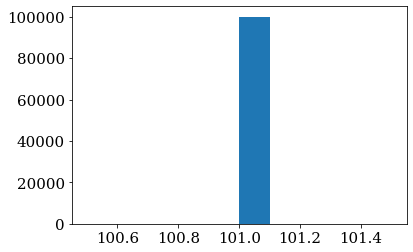

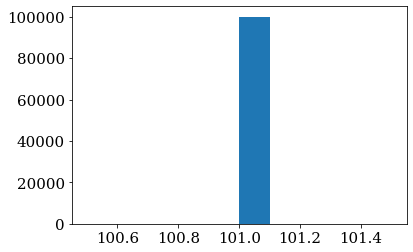

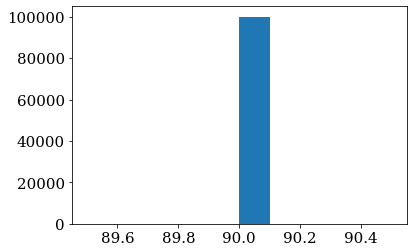

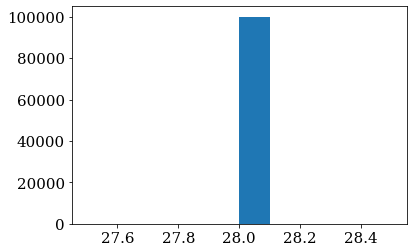

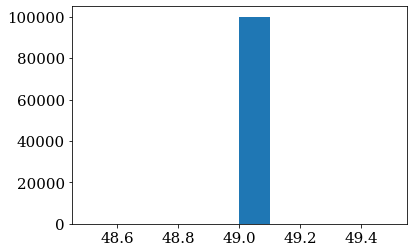

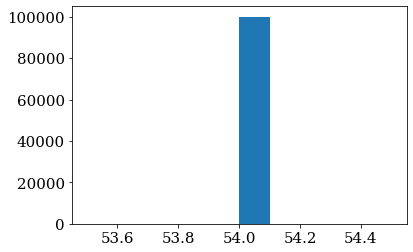

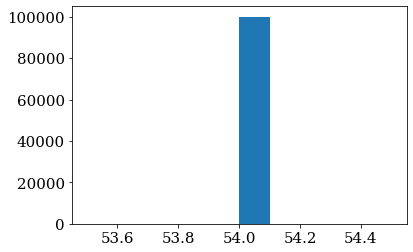

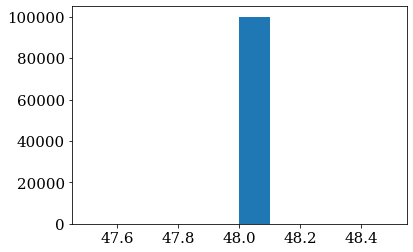

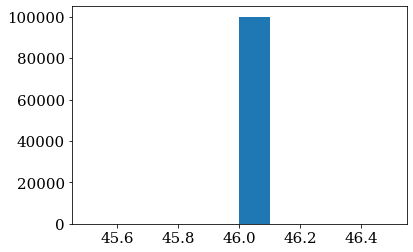

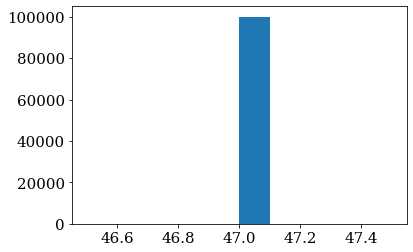

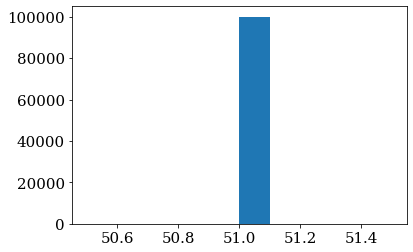

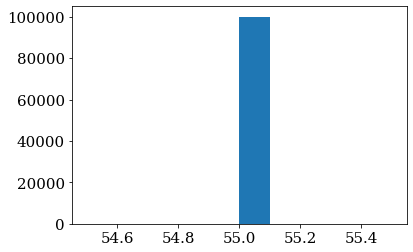

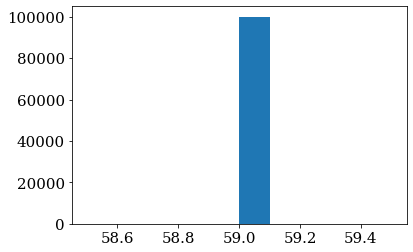

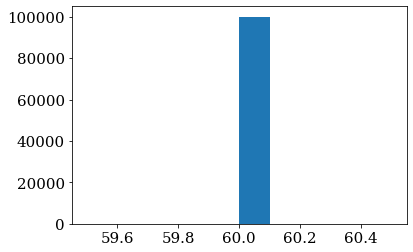

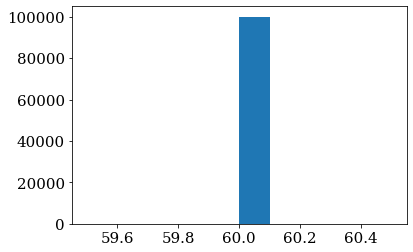

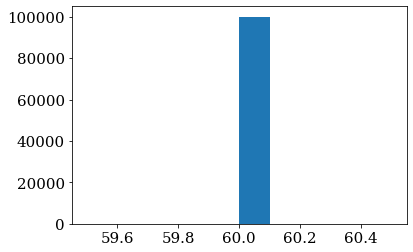

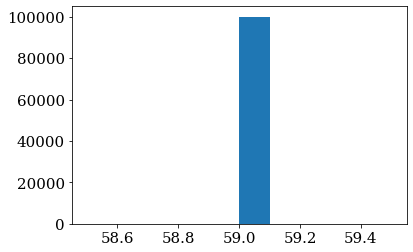

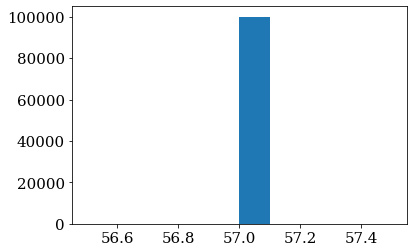

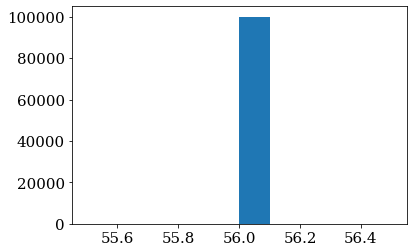

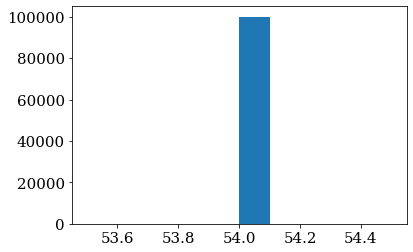

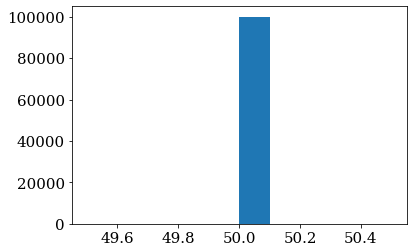

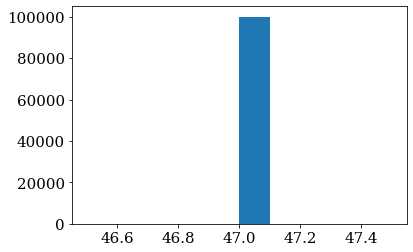

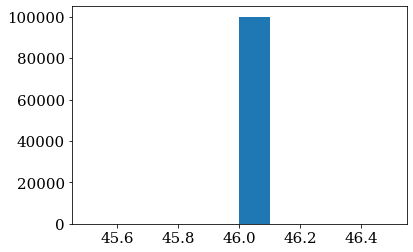

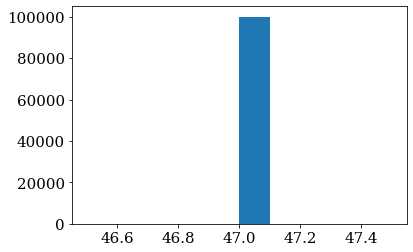

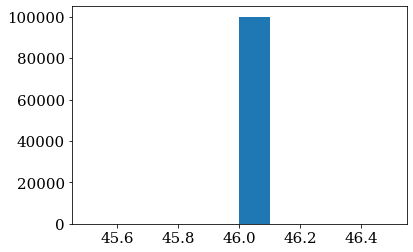

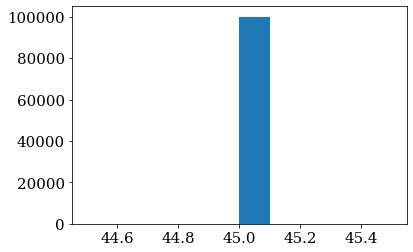

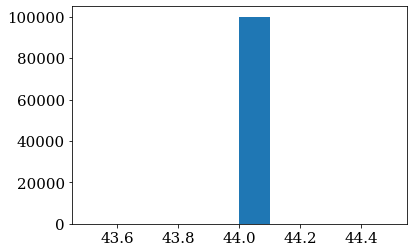

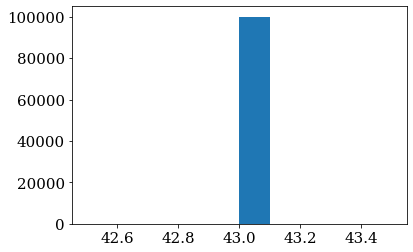

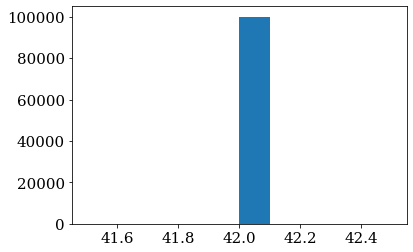

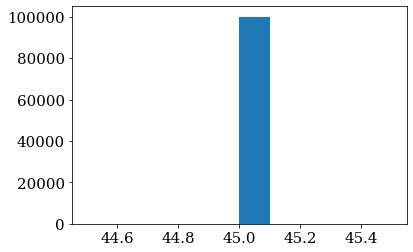

In [100]:
for i in range(30):
    plt.hist(classes[:,i])
    plt.show()

In [85]:
for i in range(10):
    print("-------------------")
    val = sub_sample[i].values
    j = 15
    print(val[j])
    print("-------------------")

-------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
-------------------
-------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
-------------------
-------------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.